# Financial Data Strategies

# Set up Environment

In [54]:
import yfinance as yf
import mplfinance as mpf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

get data

In [55]:
# Define the cryptocurrency symbol and the date range
symbol = ['BTC-USD']  # Ethereum
start_date = '2018-01-01'
end_date = '2024-11-01'

# Retrieve the historical price data for the specified cryptocurrency symbols
data = yf.download(symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [56]:
df = data["Close"].to_frame() #Extracts only the "Close" column
df.rename(columns={"Close":"Price"}, inplace=True) # Rename column

# Data Exploration

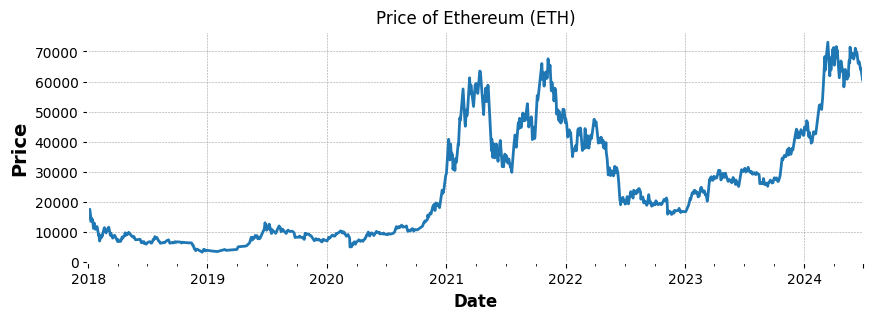

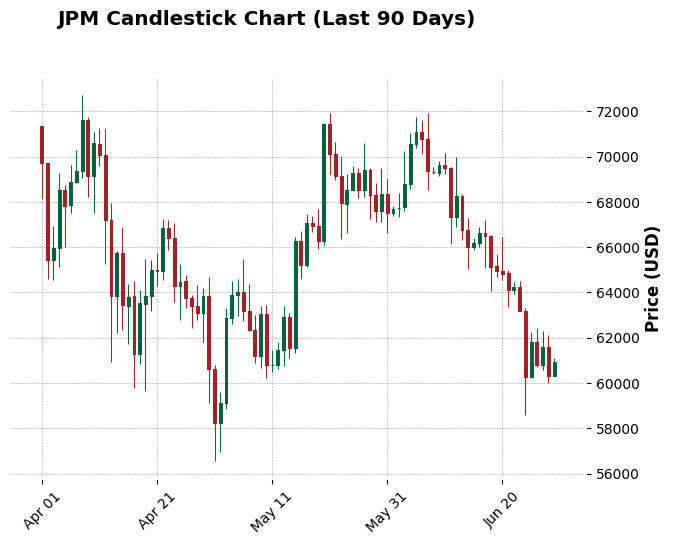

In [57]:
df["Price"].plot(title="Price of Ethereum (ETH)", figsize=(10,3))
plt.ylabel("Price", fontsize=14)

# Create a candlestick chart for JPM
mpf.plot(data[-90:], type='candle', style='charles',
         title='JPM Candlestick Chart (Last 90 Days)',
         ylabel='Price (USD)')

# Data Prep

SMA

In [58]:
# Calculate the Simple Moving Average (SMA) for JPM
df['SMA_50'] = df['Price'].rolling(window=50).mean()
df['SMA_200'] = df['Price'].rolling(window=200).mean()

# Drop rows with missing values (NaN) resulted from calculating returns
df.dropna(inplace=True)

EMA

In [59]:
#  Calculate the 50-day Exponential Moving Average 
df["EMA (50)"] = df["Price"].ewm(50, min_periods=50).mean()

# Calculate the 200-day Exponential Moving Average 
df["EMA (200)"] = df["Price"].rolling(200, min_periods=200).mean()

# Remove rows with missing values (NaN) resulting from calculations
df.dropna(inplace=True)

# Strategies

SMA

In [60]:
class MovingAverageCrossoverStrategy:
    def __init__(self, short_window, long_window):
        self.short_window = short_window
        self.long_window = long_window

    def generate_signals(self, data):
        signals = pd.DataFrame(index=data.index)
        signals['signal'] = 0.0
        signals['short_mavg'] = df['Price'].rolling(window=self.short_window, min_periods=1).mean()
        signals['long_mavg'] = df['Price'].rolling(window=self.long_window, min_periods=1).mean()
        signals['signal'][self.short_window:] = np.where(signals['short_mavg'][self.short_window:] 
                                                         > signals['long_mavg'][self.short_window:], 1.0, 0.0)
        signals['positions'] = signals['signal'].diff()
        return signals

In [61]:
# Apply the SMA Strategy
strategy = MovingAverageCrossoverStrategy(short_window=50, long_window=200)
signals = strategy.generate_signals(df)

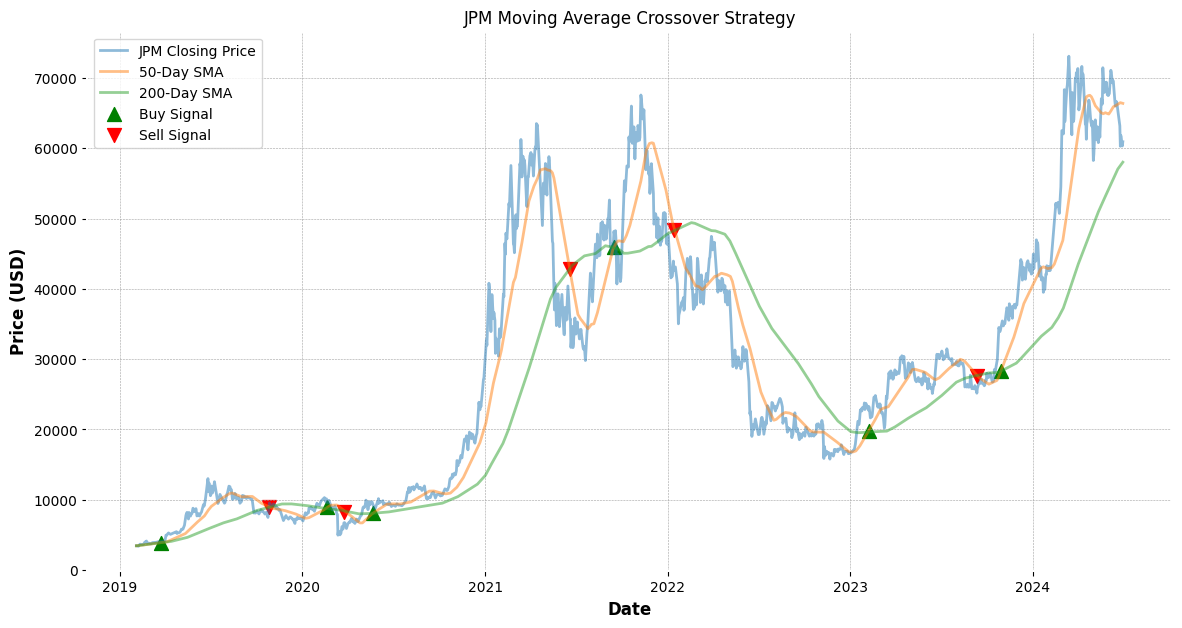

In [62]:
# Plot the signals along with the closing price
plt.figure(figsize=(14, 7))
plt.plot(df['Price'], label='JPM Closing Price', alpha=0.5)
plt.plot(signals['short_mavg'], label='50-Day SMA', alpha=0.5)
plt.plot(signals['long_mavg'], label='200-Day SMA', alpha=0.5)
plt.scatter(signals.loc[signals.positions == 1.0].index, 
            signals.short_mavg[signals.positions == 1.0],
            label='Buy Signal', marker='^', color='g', s=100)
plt.scatter(signals.loc[signals.positions == -1.0].index, 
            signals.short_mavg[signals.positions == -1.0],
            label='Sell Signal', marker='v', color='r', s=100)
plt.title('JPM Moving Average Crossover Strategy')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)

# EMA

In [63]:
# Create a Position column (1 for buy, -1 for sell)
df['Positions'] = np.where(df["EMA (50)"] > df["EMA (200)"], 1, -1)
df["Trades"]=df["Positions"].diff().fillna(0).abs()

<AxesSubplot: title={'center': 'ETH with EMA(50), EMA(200) and Poistions'}, xlabel='Date'>

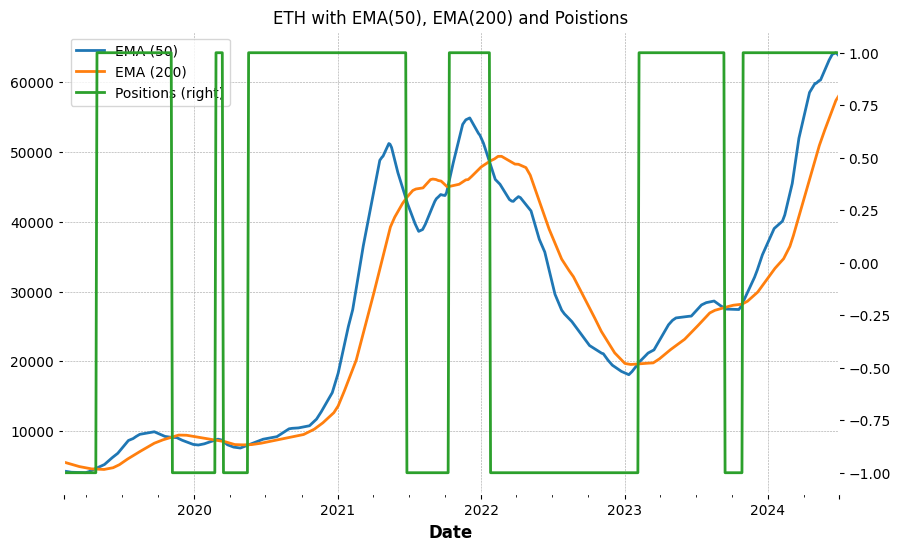

In [64]:
# Create a plot displaying the "50-day EMA," "200-day EMA," and the "Positions" column.
df.loc[:,["EMA (50)", "EMA (200)", "Positions"]].plot(title = F"ETH with EMA(50), EMA(200) and Poistions" , figsize=(10,6), secondary_y="Positions")